<a href="https://colab.research.google.com/github/samsung-chow/324-Project/blob/main/tree_models/XGB_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Upload cleaned_data.CSV (in github repo)
from google.colab import files
uploaded = files.upload()

Saving cleaned_data.CSV to cleaned_data.CSV


In [4]:
!pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import cross_val_score
# Load data
df = pd.read_csv('cleaned_data.CSV')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.6 MB/s eta 0:00:00


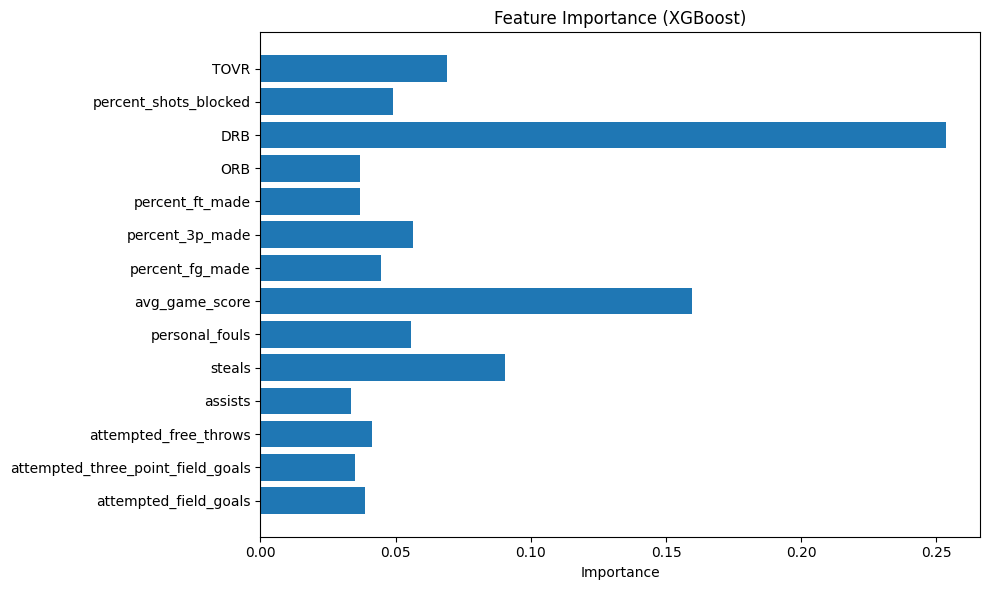

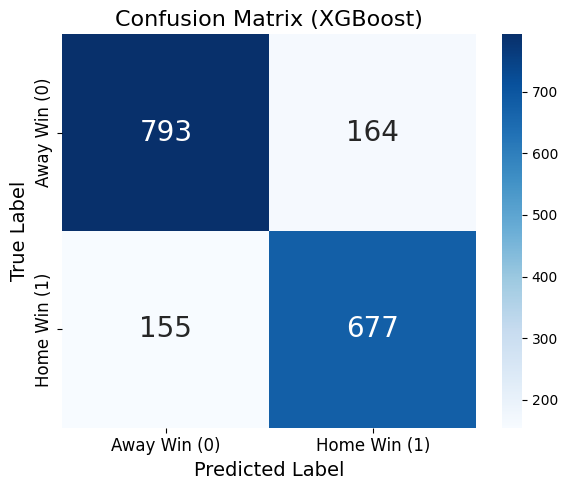

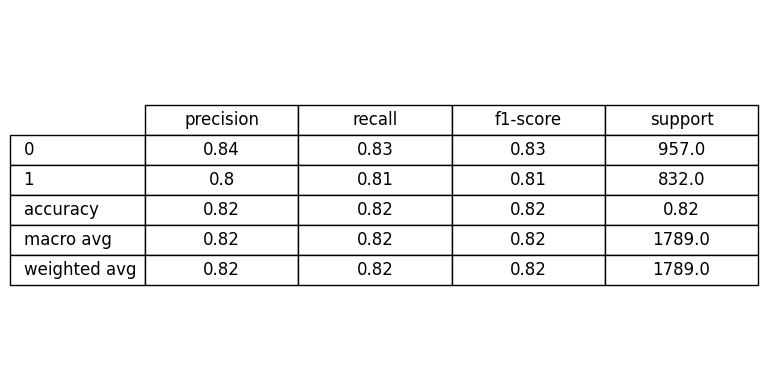

In [5]:
# Feature columns
feature_cols = [
    'attempted_field_goals',
    'attempted_three_point_field_goals',
    'attempted_free_throws',
    'assists',
    'steals',
    'personal_fouls',
    'avg_game_score',
    'percent_fg_made',
    'percent_3p_made',
    'percent_ft_made',
    'ORB',
    'DRB',
    'percent_shots_blocked',
    'TOVR'
]

# Inputs and outputs
X = df[feature_cols]
y = df['team_win']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Feature importance
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_cols, importances)
plt.xlabel("Importance")
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# Confusion Matrix
class_labels = ['Away Win (0)', 'Home Win (1)']
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_labels, yticklabels=class_labels,
                 annot_kws={"size": 20})
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Confusion Matrix (XGBoost)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Classification Report Table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
tbl = ax.table(cellText=report_df.round(2).values,
               colLabels=report_df.columns,
               rowLabels=report_df.index,
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.5)
plt.tight_layout()
plt.show()

In [6]:
# Hyper-param tuning
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 0.001, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 5.0, log=True),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)
    score = cross_val_score(
        model, X_train, y_train, cv=3, scoring='accuracy'
    ).mean()

    return score